Importação das Bibliotecas

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import numpy as np
import os

import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='keras')

Montar drive no Google Colab

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

Definição de parâmetros

In [3]:
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 10

# Parâmetros de divisão do dataset
TRAIN_SPLIT = 0.7     # 70% para treino
VAL_SPLIT = 0.15      # 15% para validação
TEST_SPLIT = 0.15     # 15% para teste

# Verificação de segurança para garantir que os splits somam 1
assert abs(TRAIN_SPLIT + VAL_SPLIT + TEST_SPLIT - 1.0) < 1e-9, "Os splits devem somar 1"

Preparação dos dados

In [4]:
def prepare_data(data_dir, train_split=TRAIN_SPLIT, val_split=VAL_SPLIT, test_split=TEST_SPLIT):

    validation_split = (val_split + test_split) / (train_split + val_split + test_split)

    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        validation_split=validation_split
    )

    # Gerador para dados de teste (apenas rescale)
    test_datagen = ImageDataGenerator(rescale=1./255)

    # Carregar dados de treino
    train_generator = train_datagen.flow_from_directory(
        data_dir,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='binary',
        subset='training',
        seed=42
    )

    # Carregar dados de validação e teste
    temp_val_generator = train_datagen.flow_from_directory(
        data_dir,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='binary',
        subset='validation',
        seed=42
    )

    # Ajustar a proporção entre validação e teste
    val_ratio = val_split / (val_split + test_split)
    n_val = int(len(temp_val_generator.filenames) * val_ratio)
    
    # Criar geradores separados para validação e teste
    validation_generator = train_datagen.flow_from_directory(
        data_dir,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='binary',
        subset='validation',
        seed=42,
        shuffle=False
    )

    test_generator = test_datagen.flow_from_directory(
        data_dir,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='binary',
        shuffle=False
    )

    print(f"\nDivisão do dataset:")
    print(f"Treino: {len(train_generator.filenames)} imagens ({train_split*100:.1f}%)")
    print(f"Validação: {n_val} imagens ({val_split*100:.1f}%)")
    print(f"Teste: {len(temp_val_generator.filenames) - n_val} imagens ({test_split*100:.1f}%)")

    return train_generator, validation_generator, test_generator

Criar o modelo com Transfer Learning

In [5]:
def create_model():
    # Carregar o modelo base MobileNetV2 pré-treinado
    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )

    # Congelar as camadas do modelo base
    base_model.trainable = False

    # Criar o modelo completo
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.2),
        # 1 neurônio para classificação binária
        layers.Dense(1, activation='sigmoid')
    ])

    return model

Treinar o modelo

In [6]:
def train_model(model, train_generator, validation_generator):
    # Compilar o modelo
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    # Treinar o modelo
    history = model.fit(
        train_generator,
        epochs=EPOCHS,
        validation_data=validation_generator
    )

    return history

Treina e avalia uma Random Forest para comparação

In [7]:
def train_random_forest(train_generator, test_generator):
    """
    Treina e avalia uma Random Forest para comparação
    """
    # Preparar dados para Random Forest
    X_train = []
    y_train = []

    for i in range(len(train_generator)):
        batch_x, batch_y = train_generator[i]
        X_train.extend(batch_x.reshape(batch_x.shape[0], -1))
        y_train.extend(batch_y)

    X_train = np.array(X_train)
    y_train = np.array(y_train)

    # Treinar Random Forest
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)

    # Preparar dados de teste
    X_test = []
    y_test = []

    for i in range(len(test_generator)):
        batch_x, batch_y = test_generator[i]
        X_test.extend(batch_x.reshape(batch_x.shape[0], -1))
        y_test.extend(batch_y)

    X_test = np.array(X_test)
    y_test = np.array(y_test)

    # Fazer predições
    y_pred_rf = rf.predict(X_test)
    y_pred_proba_rf = rf.predict_proba(X_test)[:, 1]

    # Calcular métricas
    cm_rf = confusion_matrix(y_test, y_pred_rf)
    fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)
    roc_auc_rf = auc(fpr_rf, tpr_rf)

    return {
        'confusion_matrix': cm_rf,
        'roc': (fpr_rf, tpr_rf, roc_auc_rf),
        'report': classification_report(y_test, y_pred_rf, target_names=['Dog', 'Fox']),
        'model': rf
    }

Funções para visualização de resultados

In [8]:
results_folder = 'results/'

def plot_training_history(history, save_path=results_folder):
    """
    Plota o histórico de treinamento com estilo aprimorado
    """
    plt.figure(figsize=(15, 5))

    # Plot Acurácia
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], color='#2ecc71',
             label='Treino', linewidth=2)
    plt.plot(history.history['val_accuracy'], color='#e74c3c',
             label='Validação', linewidth=2)
    plt.title('Acurácia do Modelo', fontsize=14, pad=15)
    plt.xlabel('Época', fontsize=12)
    plt.ylabel('Acurácia', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)

    # Plot Perda
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], color='#2ecc71',
             label='Treino', linewidth=2)
    plt.plot(history.history['val_loss'], color='#e74c3c',
             label='Validação', linewidth=2)
    plt.title('Perda do Modelo', fontsize=14, pad=15)
    plt.xlabel('Época', fontsize=12)
    plt.ylabel('Perda', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    

def plot_confusion_matrix(cm, save_path=results_folder):
    """
    Plota matriz de confusão estilizada
    """
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap='Blues')
    plt.title('Matriz de Confusão', fontsize=14, pad=15)
    plt.colorbar()

    classes = ['Dog', 'Fox']
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    # Adicionar valores na matriz
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.xlabel('Predito', fontsize=12)
    plt.ylabel('Real', fontsize=12)

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()


def plot_roc_curve(fpr, tpr, roc_auc, save_path=results_folder):
    """
    Plota curva ROC estilizada
    """
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='#2ecc71', lw=2,
             label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='#e74c3c', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.title('Curva ROC', fontsize=14, pad=15)
    plt.xlabel('Taxa de Falsos Positivos', fontsize=12)
    plt.ylabel('Taxa de Verdadeiros Positivos', fontsize=12)
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(True, alpha=0.3)

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()


def compare_models(cnn_results, rf_results, save_path=results_folder):
    """
    Compara os resultados do CNN e Random Forest
    """
    plt.figure(figsize=(10, 8))

    # Plot ROC curves
    plt.plot(cnn_results['roc'][0], cnn_results['roc'][1],
             label=f'CNN (AUC = {cnn_results["roc"][2]:.2f})',
             color='#2ecc71', linewidth=2)
    plt.plot(rf_results['roc'][0], rf_results['roc'][1],
             label=f'Random Forest (AUC = {rf_results["roc"][2]:.2f})',
             color='#e74c3c', linewidth=2)
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taxa de Falsos Positivos', fontsize=12)
    plt.ylabel('Taxa de Verdadeiros Positivos', fontsize=12)
    plt.title('Comparação das Curvas ROC', fontsize=14, pad=15)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

Mostra informações detalhadas sobre os conjuntos de dados

In [9]:
def show_dataset_info(train_generator, val_generator, test_generator):
    """
    Mostra informações detalhadas sobre os conjuntos de dados
    """
    total_images = (len(train_generator.filenames) +
                    len(val_generator.filenames) +
                    len(test_generator.filenames))

    print("\n" + "="*50)
    print("INFORMAÇÕES DO DATASET".center(50))
    print("="*50)

    print(f"\nTotal de imagens: {total_images}")

    # Informações do conjunto de treino
    print("\n" + "-"*20 + " TREINO " + "-"*20)
    print(f"Total: {len(train_generator.filenames)} imagens")
    print(f"Proporção: {len(train_generator.filenames)/total_images:.1%}")
    class_dist = dict(zip(train_generator.class_indices.keys(),
                          np.bincount(train_generator.classes)))
    for cls, count in class_dist.items():
        print(f"{cls}: {count} imagens")

    # Informações do conjunto de validação
    print("\n" + "-"*20 + " VALIDAÇÃO " + "-"*20)
    print(f"Total: {len(val_generator.filenames)} imagens")
    print(f"Proporção: {len(val_generator.filenames)/total_images:.1%}")
    class_dist = dict(zip(val_generator.class_indices.keys(),
                          np.bincount(val_generator.classes)))
    for cls, count in class_dist.items():
        print(f"{cls}: {count} imagens")

    # Informações do conjunto de teste
    print("\n" + "-"*20 + " TESTE " + "-"*20)
    print(f"Total: {len(test_generator.filenames)} imagens")
    print(f"Proporção: {len(test_generator.filenames)/total_images:.1%}")
    class_dist = dict(zip(test_generator.class_indices.keys(),
                          np.bincount(test_generator.classes)))
    for cls, count in class_dist.items():
        print(f"{cls}: {count} imagens")
    print("\n" + "="*50)

Função para avaliar o modelo

In [10]:
# Função para avaliar o modelo
def evaluate_model(model, test_generator):
    """
    Avalia o modelo usando várias métricas
    """
    # Fazer predições
    predictions = model.predict(test_generator)
    y_pred = (predictions > 0.5).astype(int)
    y_true = test_generator.classes

    # Calcular matriz de confusão
    cm = confusion_matrix(y_true, y_pred)

    # Calcular ROC e AUC
    fpr, tpr, _ = roc_curve(y_true, predictions)
    roc_auc = auc(fpr, tpr)

    # Gerar relatório de classificação
    report = classification_report(y_true, y_pred, target_names=['Dog', 'Fox'])

    return {
        'confusion_matrix': cm,
        'roc': (fpr, tpr, roc_auc),
        'report': report,
        'y_true': y_true,
        'y_pred': y_pred,
        'predictions': predictions
    }

Função para fazer previsões com novas imagens

In [11]:
def predict_image(image_path):
    # Carregar o modelo salvo
    model = tf.keras.models.load_model('models/dog_fox_classifier.keras')

    # Carregar e preprocessar a imagem
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Normalização

    # Fazer a predição
    prediction = model.predict(img_array)

    # Interpretar o resultado
    # Como usamos classificação binária, valores próximos a 0 indicam a primeira classe (dog)
    # e valores próximos a 1 indicam a segunda classe (fox)
    class_names = ['dog', 'fox']
    # Corrigido: extrair o valor escalar do array
    pred_value = prediction[0].item()  # Converte para escalar
    predicted_class = class_names[int(pred_value > 0.5)]
    confidence = pred_value if pred_value > 0.5 else 1 - pred_value

    return predicted_class, float(confidence)

Função principal para treinar e avaliar o modelo

In [ ]:
def main(train_split=TRAIN_SPLIT, val_split=VAL_SPLIT, test_split=TEST_SPLIT):
    
    # Definir o diretório dos dados
    data_dir = 'dataset/'

    # Preparar os dados com os splits especificados
    train_generator, validation_generator, test_generator = prepare_data(
        data_dir,
        train_split=train_split,
        val_split=val_split,
        test_split=test_split
    )
    
    # Mostrar informações do dataset
    show_dataset_info(train_generator, validation_generator, test_generator)

    # Criar o modelo
    model = create_model()
    history = train_model(model, train_generator, validation_generator)
    
    # Avaliar o modelo CNN
    cnn_results = evaluate_model(model, test_generator)

    # Treinar e avaliar Random Forest
    rf_results = train_random_forest(train_generator, test_generator)
    
    # Plotar resultados
    plot_training_history(history, save_path='results/training_history.png')
    plot_confusion_matrix(cnn_results['confusion_matrix'], save_path='results/cnn_confusion_matrix.png')
    plot_roc_curve(*cnn_results['roc'], save_path='results/cnn_roc_curve.png')
    compare_models(cnn_results, rf_results, save_path='results/model_comparison.png')
    
    # Imprimir relatórios de classificação
    print("\nRelatório de Classificação - CNN:")
    print(cnn_results['report'])
    print("\nRelatório de Classificação - Random Forest:")
    print(rf_results['report'])
    
    # Avaliar no conjunto de teste
    test_loss, test_accuracy = model.evaluate(test_generator)
    print(f'\nDesempenho no conjunto de teste:')
    print(f'Acurácia: {test_accuracy:.4f}')
    print(f'Loss: {test_loss:.4f}')

    # Salvar o modelo
    model.save('models/dog_fox_classifier.keras')

Execução da função principal para treinar e avaliar o modelo

Found 146 images belonging to 2 classes.
Found 61 images belonging to 2 classes.
Found 61 images belonging to 2 classes.
Found 207 images belonging to 2 classes.

Divisão do dataset:
Treino: 146 imagens (70.0%)
Validação: 30 imagens (15.0%)
Teste: 31 imagens (15.0%)

              INFORMAÇÕES DO DATASET              

Total de imagens: 414

-------------------- TREINO --------------------
Total: 146 imagens
Proporção: 35.3%
dog: 74 imagens
fox: 72 imagens

-------------------- VALIDAÇÃO --------------------
Total: 61 imagens
Proporção: 14.7%
dog: 31 imagens
fox: 30 imagens

-------------------- TESTE --------------------
Total: 207 imagens
Proporção: 50.0%
dog: 105 imagens
fox: 102 imagens



c:\Program Files\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 61s 12s/step - accuracy: 0.7228 - loss: 0.4914 - val_accuracy: 0.9508 - val_loss: 0.1474
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 41s 9s/step - accuracy: 0.9577 - loss: 0.0960 - val_accuracy: 0.9344 - val_loss: 0.2004
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 42s 8s/step - accuracy: 0.9691 - loss: 0.0990 - val_accuracy: 0.9508 - val_loss: 0.1805
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 43s 10s/step - accuracy: 0.9942 - loss: 0.0392 - val_accuracy: 0.9508 - val_loss: 0.1694
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 41s 8s/step - accuracy: 0.9871 - loss: 0.0278 - val_accuracy: 0.9344 - val_loss: 0.1659
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 42s 9s/step - accuracy: 1.0000 - loss: 0.0048 - val_accuracy: 0.9508 - val_loss: 0.2344
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 42s 9s/step - accuracy: 0.9814 - loss: 0.0441 - val_accuracy: 0.9672 - val_loss: 0.1441
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 44s 9s/step - accuracy: 1.0000 - loss: 0.0047 - val_accuracy: 0.9836 - val_loss: 0.0791
Epoch 

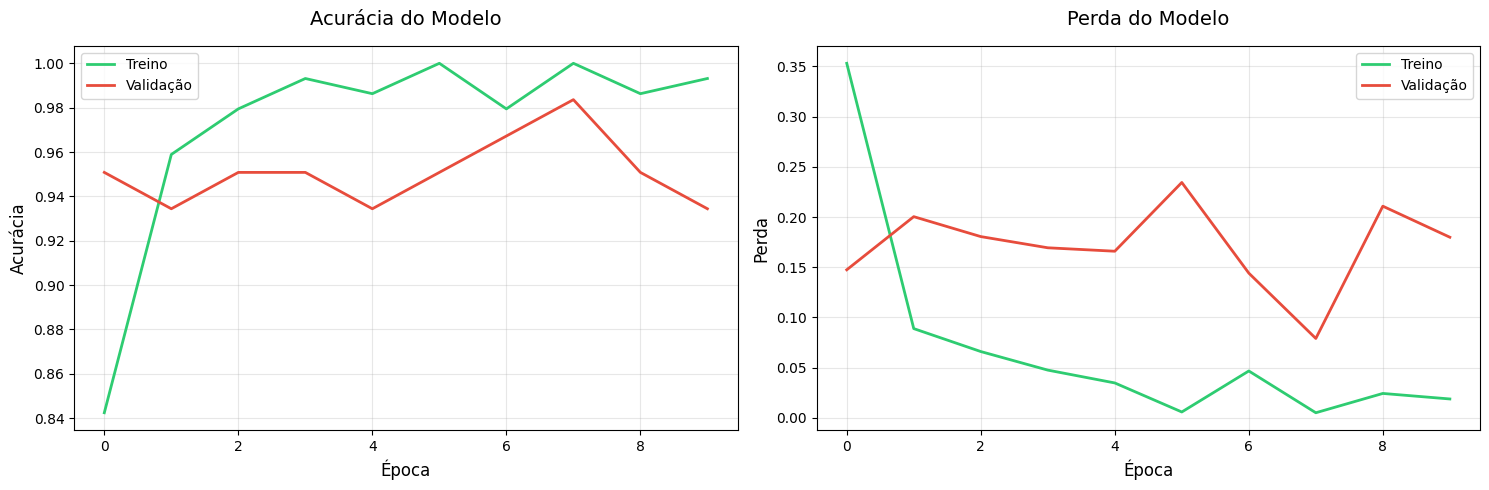

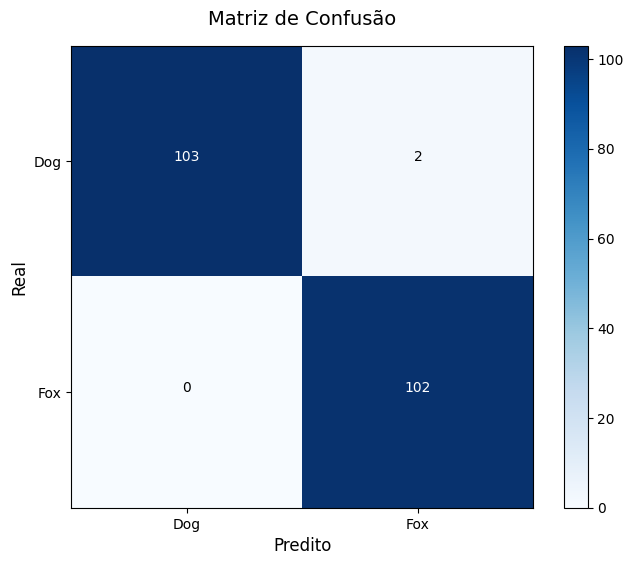

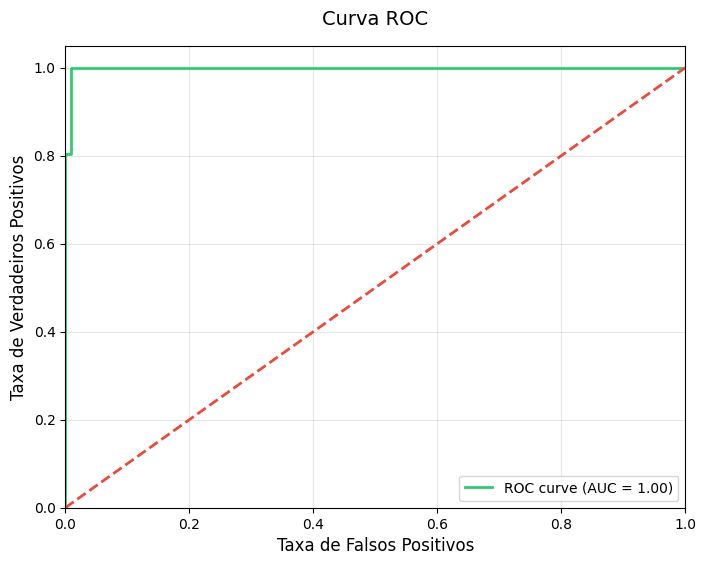

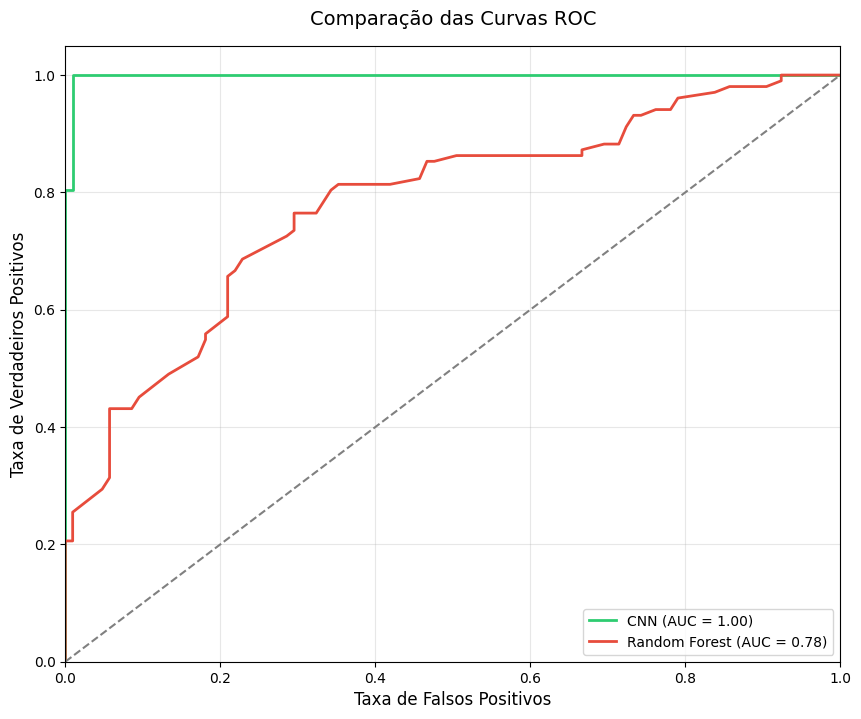


Relatório de Classificação - CNN:
              precision    recall  f1-score   support

         Dog       1.00      0.98      0.99       105
         Fox       0.98      1.00      0.99       102

    accuracy                           0.99       207
   macro avg       0.99      0.99      0.99       207
weighted avg       0.99      0.99      0.99       207


Relatório de Classificação - Random Forest:
              precision    recall  f1-score   support

         Dog       0.73      0.70      0.72       105
         Fox       0.71      0.74      0.72       102

    accuracy                           0.72       207
   macro avg       0.72      0.72      0.72       207
weighted avg       0.72      0.72      0.72       207

7/7 ━━━━━━━━━━━━━━━━━━━━ 42s 6s/step - accuracy: 0.9784 - loss: 0.0946

Desempenho no conjunto de teste:
Acurácia: 0.9903
Loss: 0.0443


In [13]:
# Treinar o modelo com os splits padrão
main(train_split=0.7, val_split=0.15, test_split=0.15)